<a href="https://colab.research.google.com/github/rajy4683/EVA4S4/blob/master/S4EVA4_Attempt5_9945.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final Accuracy: 99.46
###  Number of parameters - 9122

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np

In [0]:
!pip install pytorch-ignite
!pip install torchsummary
!pip install wandb

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from torch.utils.data import DataLoader
from ignite.handlers import Checkpoint, DiskSaver


import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

from argparse import ArgumentParser
from tqdm import tqdm
import os

In [0]:
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

In [0]:
import wandb
#wandb.init()
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
#wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_val = 0.1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),            
            nn.Dropout(self.dropout_val)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val)
        )
        
        self.gap_linear = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(16, 10, 1)
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        #x = x.view(x.size(0), -1)
        x = self.gap_linear(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x


In [0]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, 3, padding=1) #input -? OUtput? RF
#         self.conv1_bn = nn.BatchNorm2d(8)
#         self.dropout_val = 0.00001
#         self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
#         self.conv2_bn = nn.BatchNorm2d(16)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
#         self.conv3_bn = nn.BatchNorm2d(16)
#         self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
#         self.conv4_bn = nn.BatchNorm2d(16)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.conv5 = nn.Conv2d(16, 16, 3)
#         self.conv5_bn = nn.BatchNorm2d(16)
#         self.conv6 = nn.Conv2d(16, 16, 3)
#         self.conv6_bn = nn.BatchNorm2d(16)

#         self.conv7 = nn.Conv2d(16, 10, 1)

#     def forward(self, x):
#         # x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
#         # x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
#         # x = F.relu(self.conv6(F.relu(self.conv5(x))))
#         # x = F.relu(self.conv7(x))
#         # x = x.view(-1, 10)
#         # return F.log_softmax(x)
        

#         # x = F.dropout2d(self.conv1_bn(F.relu(self.conv1(x))),self.dropout_val) ### Layer 1 ---->(Relu(BN(Conv)))
#         # x = self.pool1(F.dropout2d(self.conv2_bn(F.relu(self.conv2(x))),self.dropout_val)) ### Layer 2---> MaxPool((Relu(BN(Conv))))
#         # x = F.dropout2d(self.conv3_bn(F.relu(self.conv3(x))),self.dropout_val) ### Layer 3 ---->(Relu(BN(Conv)))
#         # x = self.pool2(F.dropout2d(self.conv4_bn(F.relu(self.conv4(x))),self.dropout_val)) ### Layer 4---> MaxPool((Relu(BN(Conv))))
#         # #########
#         # x = F.dropout2d(self.conv5_bn(F.relu(self.conv5(x))),self.dropout_val) ### Layer 5---> (Relu(BN(Conv)))        
#         # #x = F.adaptive_avg_pool2d(F.relu(self.conv6_bn(self.conv6(x))),(1,1))### Layer 6 ---> (Relu(BN(Conv))) F.adaptive_avg_pool2d(x, (1, 1))
#         # x = F.dropout2d(self.conv6_bn(F.relu(self.conv6(x))),self.dropout_val)
#         # x = F.adaptive_avg_pool2d(x, (1, 1))
#         # #F.avg_pool2d(x,x.size()[2:])### Layer 6 ---> (Relu(BN(Conv))) F.adaptive_avg_pool2d(x, (1, 1))
#         # x = self.conv7(x) #### Final Layer (Conv)
#         # x = x.view(-1, 10)


#         x = F.relu(self.conv1_bn(self.conv1(x))) ### Layer 1 ---->(Relu(BN(Conv)))
#         x = self.pool1(F.relu(self.conv2_bn(self.conv2(x)))) ### Layer 2---> MaxPool((Relu(BN(Conv))))
#         x = F.relu(self.conv3_bn(self.conv3(x))) ### Layer 3 ---->(Relu(BN(Conv)))
#         x = self.pool2(F.relu(self.conv4_bn(self.conv4(x)))) ### Layer 4---> MaxPool((Relu(BN(Conv))))
#         #########
#         x = F.relu(self.conv5_bn(self.conv5(x))) ### Layer 5---> (Relu(BN(Conv)))        
#         #x = F.adaptive_avg_pool2d(F.relu(self.conv6_bn(self.conv6(x))),(1,1))### Layer 6 ---> (Relu(BN(Conv))) F.adaptive_avg_pool2d(x, (1, 1))
#         x = F.relu(self.conv6_bn(self.conv6(x)))
#         x = F.adaptive_avg_pool2d(x, (1, 1))
#         #F.avg_pool2d(x,x.size()[2:])### Layer 6 ---> (Relu(BN(Conv))) F.adaptive_avg_pool2d(x, (1, 1))
#         x = self.conv7(x) #### Final Layer (Conv)
#         x = x.view(-1, 10)
#         return F.log_softmax(x)

In [0]:
Net

__main__.Net

In [0]:
# class Net(nn.Module):
#     def __init__(self,start_channels=32, exponetate_layers=True):
#         super(Net, self).__init__()
#         self.start_channels = start_channels
#         self.multiplier = 2

#         if (exponetate_layers == False):
#             self.multiplier = 1
        
#         self.conv1 = nn.Conv2d(1, self.start_channels, 3, padding=1) #input -? OUtput? RF
#         self.conv1_bn = nn.BatchNorm2d(self.start_channels)
#         self.conv2 = nn.Conv2d(self.start_channels, self.start_channels*self.multiplier, 3, padding=1)
#         self.conv2_bn = nn.BatchNorm2d(self.start_channels*self.multiplier)

#         self.start_channels = self.start_channels * self.multiplier
#         self.pool1 = nn.MaxPool2d(2, 2)

#         self.conv3 = nn.Conv2d(self.start_channels, self.start_channels*self.multiplier, 3, padding=1)
#         self.conv3_bn = nn.BatchNorm2d(self.start_channels*self.multiplier)
#         #self.start_channels = self.start_channels * self.multiplier
#         self.conv4 = nn.Conv2d(self.start_channels, self.start_channels*self.multiplier, 3, padding=1)
#         self.conv4_bn = nn.BatchNorm2d(self.start_channels*self.multiplier)
#         #self.start_channels = self.start_channels * self.multiplier
#         self.pool2 = nn.MaxPool2d(2, 2)


#         # self.conv5 = nn.Conv2d(self.start_channels, self.start_channels*self.multiplier, 3)
#         # self.conv5_bn = nn.BatchNorm2d(self.start_channels*self.multiplier)
#         # #self.start_channels = self.start_channels * self.multiplier
#         # self.conv6 = nn.Conv2d(self.start_channels, self.start_channels*self.multiplier, 3)
#         # self.conv6_bn = nn.BatchNorm2d(self.start_channels*self.multiplier)
#         # #self.start_channels = self.start_channels * self.multiplier

#         # self.conv7 = nn.Conv2d(self.start_channels, 10, 1)

#     def forward(self, x):
#         x = F.relu(self.conv1_bn(self.conv1(x))) ### Layer 1 ---->(Relu(BN(Conv)))
#         x = self.pool1(F.relu(self.conv2_bn(self.conv2(x)))) ### Layer 2---> MaxPool((Relu(BN(Conv))))
#         x = F.relu(self.conv3_bn(self.conv3(x))) ### Layer 3 ---->(Relu(BN(Conv)))
#         x = self.pool2(F.relu(self.conv4_bn(self.conv4(x)))) ### Layer 4---> MaxPool((Relu(BN(Conv))))
#         #########
#         x = F.relu(self.conv5_bn(self.conv5(x))) ### Layer 5---> (Relu(BN(Conv)))        
#         #x = F.adaptive_avg_pool2d(F.relu(self.conv6_bn(self.conv6(x))),(1,1))### Layer 6 ---> (Relu(BN(Conv))) F.adaptive_avg_pool2d(x, (1, 1))
#         x = F.relu(self.conv6_bn(self.conv6(x)))
#         x = F.avg_pool2d(x,x.size()[2:])### Layer 6 ---> (Relu(BN(Conv))) F.adaptive_avg_pool2d(x, (1, 1))
#         x = self.conv7(x) #### Final Layer (Conv)
#         x = x.view(-1, 10)
#         return F.log_softmax(x)

In [0]:
# model = Net(start_channels=8,exponetate_layers=True).to(device)
# summary(model, input_size=(1, 28, 28))
# #wandb.watch(model, log="all")

In [0]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             584
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         MaxPool2d-8            [-1, 8, 14, 14]               0
           Dropout-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,168
             ReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
          Dropout-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

In [0]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
train_loader.dataset.data.shape

torch.Size([60000, 28, 28])

In [0]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

from tqdm import tqdm
def train(args, model, device, train_loader, optimizer, epoch_number):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch_number, train_loss, train_accuracy, len(train_loader.dataset),
        100. * train_accuracy / len(train_loader.dataset)))
    
    wandb.log({        
        "Train Accuracy": 100. * train_accuracy / len(train_loader.dataset),
        "Train Loss": train_loss})


def test(args, model, device, test_loader,classes,epoch_number):
    model.eval()
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        #example_images.append(wandb.Image(
        #        data[0], caption="Pred: {} Truth: {}".format(classes[pred[0].item()], classes[target[0]])))

    test_loss /= len(test_loader.dataset)

    print('\nEpoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch_number, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    
    wandb.log({
        "Test Accuracy": 100. * correct / len(test_loader.dataset),
        "Test Loss": test_loss})


In [0]:
#model = Net(start_channels=16,exponetate_layers=False).to(device)
wandb.init(project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = 64          # input batch size for training (default: 64)
config.test_batch_size = config.batch_size    # input batch size for testing (default: 1000)
config.epochs = 20             # number of epochs to train (default: 10)
config.lr = 0.01               # learning rate (default: 0.01)
config.momentum = 0.9          # SGD momentum (default: 0.5) 
config.no_cuda = False         # disables CUDA training
config.seed = 1               # random seed (default: 42)
config.log_interval = 10     # how many batches to wait before logging training status

def main():
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    
    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config.seed) # pytorch random seed
    # numpy.random.seed(config.seed) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # Load the dataset: We're training our CNN on CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)
    # First we define the tranformations to apply to our images
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=config.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=config.batch_size, shuffle=True, **kwargs)

    # Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum)
    
    # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
    # Using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")

    for epoch in range(1, config.epochs + 1):
        train(config, model, device, train_loader, optimizer, epoch)
        test(config, model, device, test_loader, classes,epoch)
        
    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
    torch.save(model.state_dict(), "model.h5")
    wandb.save('model.h5')

if __name__ == '__main__':
    main()





# model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# wandb.watch(model, log="all")
# for epoch in range(1, 20):
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

loss=0.037439361214637756 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.51it/s]



Epoch: 1 Train set: Average loss: 0.0038, Accuracy: 55658/60000 (92.763%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 Test set: Average loss: 0.0493, Accuracy: 9844/10000 (98.440%)



loss=0.02039620280265808 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.86it/s]



Epoch: 2 Train set: Average loss: 0.0014, Accuracy: 58381/60000 (97.302%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 Test set: Average loss: 0.0340, Accuracy: 9885/10000 (98.850%)



loss=0.02358873188495636 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.97it/s]



Epoch: 3 Train set: Average loss: 0.0011, Accuracy: 58718/60000 (97.863%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 Test set: Average loss: 0.0297, Accuracy: 9899/10000 (98.990%)



loss=0.000861242413520813 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.20it/s]



Epoch: 4 Train set: Average loss: 0.0010, Accuracy: 58888/60000 (98.147%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 Test set: Average loss: 0.0280, Accuracy: 9909/10000 (99.090%)



loss=0.02046094834804535 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.46it/s]



Epoch: 5 Train set: Average loss: 0.0009, Accuracy: 58972/60000 (98.287%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 Test set: Average loss: 0.0236, Accuracy: 9916/10000 (99.160%)



loss=0.0187130868434906 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.65it/s]



Epoch: 6 Train set: Average loss: 0.0008, Accuracy: 59027/60000 (98.378%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 Test set: Average loss: 0.0239, Accuracy: 9920/10000 (99.200%)



loss=0.2213306725025177 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 49.62it/s]



Epoch: 7 Train set: Average loss: 0.0008, Accuracy: 59133/60000 (98.555%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 Test set: Average loss: 0.0204, Accuracy: 9929/10000 (99.290%)



loss=0.01403738558292389 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.84it/s]



Epoch: 8 Train set: Average loss: 0.0007, Accuracy: 59154/60000 (98.590%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.250%)



loss=0.12039291113615036 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 54.39it/s]



Epoch: 9 Train set: Average loss: 0.0007, Accuracy: 59212/60000 (98.687%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99.280%)



loss=0.11942537128925323 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.30it/s]



Epoch: 10 Train set: Average loss: 0.0006, Accuracy: 59285/60000 (98.808%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.460%)



loss=0.20631961524486542 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 56.37it/s]



Epoch: 11 Train set: Average loss: 0.0006, Accuracy: 59259/60000 (98.765%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.380%)



loss=0.0033655762672424316 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.51it/s]



Epoch: 12 Train set: Average loss: 0.0006, Accuracy: 59247/60000 (98.745%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 Test set: Average loss: 0.0183, Accuracy: 9948/10000 (99.480%)



loss=0.0960254892706871 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 55.54it/s]



Epoch: 13 Train set: Average loss: 0.0006, Accuracy: 59318/60000 (98.863%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 Test set: Average loss: 0.0172, Accuracy: 9939/10000 (99.390%)



loss=0.11118742823600769 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 53.90it/s]



Epoch: 14 Train set: Average loss: 0.0006, Accuracy: 59342/60000 (98.903%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.430%)



loss=0.007760286331176758 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 54.09it/s]



Epoch: 15 Train set: Average loss: 0.0006, Accuracy: 59313/60000 (98.855%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.400%)



loss=0.01778198778629303 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 54.90it/s]



Epoch: 16 Train set: Average loss: 0.0005, Accuracy: 59385/60000 (98.975%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 Test set: Average loss: 0.0185, Accuracy: 9936/10000 (99.360%)



loss=0.00169411301612854 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 54.13it/s]



Epoch: 17 Train set: Average loss: 0.0006, Accuracy: 59319/60000 (98.865%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.400%)



loss=0.011921197175979614 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 53.61it/s]



Epoch: 18 Train set: Average loss: 0.0005, Accuracy: 59378/60000 (98.963%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 Test set: Average loss: 0.0174, Accuracy: 9943/10000 (99.430%)



loss=0.0128394216299057 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 54.54it/s]



Epoch: 19 Train set: Average loss: 0.0005, Accuracy: 59402/60000 (99.003%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.460%)



loss=0.0012746304273605347 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 53.53it/s]



Epoch: 20 Train set: Average loss: 0.0005, Accuracy: 59398/60000 (98.997%)


Epoch: 20 Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.460%)



In [0]:
from IPython.display import IFrame

IFrame(src='https://app.wandb.ai/rajy4683/news4eva4/runs/r06vb1q0?workspace=user-rajy4683',width=700, height=600)

In [0]:
def plot_metrics(metrics_dataframe_local):
    dataset_metrics = metrics_dataframe_local.loc[:,['Test Accuracy', 'Test Loss']].dropna().reset_index().drop(columns='index')
    final_run_metrics = pd.concat([metrics_dataframe.loc[:,['Train Accuracy', 'Train Loss']].dropna().reset_index().drop(columns='index'), 
                                   metrics_dataframe.loc[:,['Test Accuracy', 'Test Loss']].dropna().reset_index().drop(columns='index')],axis=1)
    final_run_metrics.loc[:,['Train Accuracy', 'Test Accuracy']].plot()
    final_run_metrics.loc[:,['Train Loss', 'Test Loss']].plot()


In [0]:
import wandb
api = wandb.Api()

# run is specified by <entity>/<project>/<run id>
run = api.run("rajy4683/news4eva4/r06vb1q0")

# save the metrics for the run to a csv file
metrics_dataframe = run.history()
metrics_dataframe.to_csv("metrics.csv")

In [0]:
dataset_metrics = metrics_dataframe.loc[:,['Test Accuracy', 'Test Loss']].dropna().reset_index().drop(columns='index')


In [0]:
metrics_dataframe.info()

In [0]:
dataset_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
Test Accuracy    20 non-null float64
Test Loss        20 non-null float64
dtypes: float64(2)
memory usage: 448.0 bytes


In [0]:
metrics_dataframe.loc[:,['Train Accuracy', 'Train Loss']].dropna().reset_index().drop(columns='index')

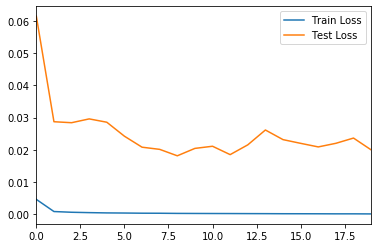

In [0]:
final_run_metrics.loc[:,['Train Loss', 'Test Loss']].plot()

In [0]:
import wandb
api = wandb.Api()

# run is specified by <entity>/<project>/<run id>
run = api.run("rajy4683/news4eva4/0i2m93s7")

# save the metrics for the run to a csv file
metrics_dataframe = run.history()
metrics_dataframe.to_csv("metrics.csv")

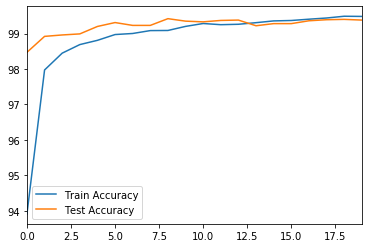

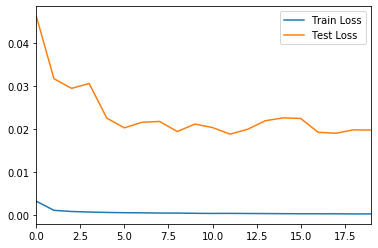

In [0]:
plot_metrics(metrics_dataframe)

In [0]:
import wandb
api = wandb.Api()

# run is specified by <entity>/<project>/<run id>
run = api.run("rajy4683/news4eva4/1i1ns4m1")

# save the metrics for the run to a csv file
metrics_dataframe = run.history()
metrics_dataframe.to_csv("metrics.csv")

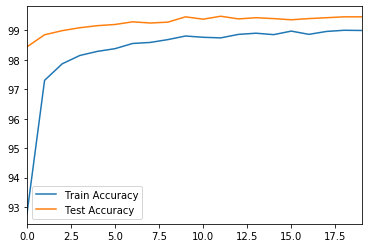

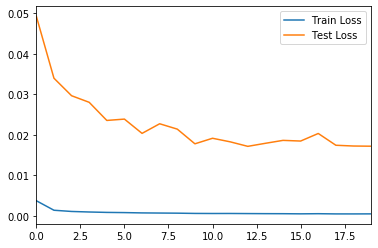

In [0]:
plot_metrics(metrics_dataframe)